In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from keras.models import load_model
import keras.backend as K
from lorenz_gan.gan import normalize_data, unnormalize_data, Split1D, Scale
from sklearn.neighbors import KernelDensity
import xarray as xr
import keras.backend as Ke
from os.path import join
from glob import glob
from multiprocessing import Pool
from dask.distributed import Client, LocalCluster
import traceback

In [2]:
cluster = LocalCluster(n_workers=8)
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:33344 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 72 Memory: 67.30 GB


In [4]:
ls /glade/work/dgagne/exp_20_stoch

annres_config_0000_mean.nc        gan_generator_0000_epoch_0009.h5
annres_config_0000_opts.yaml      gan_generator_0000_epoch_0010.h5
annres_config_0000_res.nc         gan_generator_0000_epoch_0011.h5
annres_scaling_values_0000.csv    gan_generator_0000_epoch_0012.h5
ar1_random_updater.pkl            gan_generator_0000_epoch_0013.h5
gan_000_climate/                  gan_generator_0000_epoch_0014.h5
gan_000_weather/                  gan_generator_0000_epoch_0015.h5
gan_100_climate/                  gan_generator_0000_epoch_0016.h5
gan_100_weather/                  gan_generator_0000_epoch_0017.h5
gan_101_climate/                  gan_generator_0000_epoch_0018.h5
gan_101_weather/                  gan_generator_0000_epoch_0019.h5
gan_102_climate/                  gan_generator_0000_epoch_0020.h5
gan_102_weather/                  gan_generator_0000_epoch_0022.h5
gan_103_climate/                  gan_generator_0000_epoch_0024.h5
gan_103_weather/                  gan_generator_0000_epoch_002

In [3]:
data_path = "/glade/work/dgagne/exp_20_stoch/"
test_data = pd.read_csv(join(data_path, "lorenz_combined_output_test.csv"), 
                        usecols=["x_index", "step", "time", "X_t", "Ux_t", "Ux_t+1"])

In [4]:
x_scaling_values = pd.read_csv(join(data_path, "gan_X_scaling_values_0102.csv"), index_col="Channel")
y_scaling_values = pd.read_csv(join(data_path, "gan_Y_scaling_values_0102.csv"), index_col="Channel")

In [5]:
x_cols = ["X_t", "Ux_t"]
y_cols = ["Ux_t+1"]
x_norm_data, _ = normalize_data(test_data[x_cols].values, scaling_values=x_scaling_values)
y_norm_data, _ = normalize_data(test_data[y_cols].values, scaling_values=y_scaling_values)

In [6]:
x_data_sub = x_norm_data[:200000]
y_data_sub = y_norm_data[:200000]

In [8]:
gen_files = sorted(glob(join(data_path, "gan_generator_0102_*.h5")))

In [50]:
def predict_stochastic(neural_net):
    """
    Have the neural network make predictions with the Dropout layers on, resulting in stochastic behavior from the
    neural net itself.

    Args:
        neural_net:
        data:

    Returns:

    """
    input = neural_net.input
    output = neural_net.output
    pred_func = K.function(input + [K.learning_phase()], [output])
    return pred_func

def hellinger(a, b):
    return np.sqrt(np.sum((np.sqrt(a) - np.sqrt(b)) ** 2)) / np.sqrt(2)

In [13]:
kde_true = KernelDensity(bandwidth=0.5, algorithm="kd_tree", leaf_size=100)
kde_true.fit(y_data_sub)
y_bins = np.linspace(-5, 5, 100)
true_pdf = np.exp(kde_true.score_samples(y_bins.reshape(-1,1)))

In [73]:
def calc_hellinger_epochs(index, x_data=x_data_sub, true_pdf=true_pdf, y_bins=np.linspace(-5, 5, 100), num_samples=200000):
    gen_files = sorted(glob(join(data_path, "gan_generator_{0:04d}_*.h5".format(index))))
    hds = np.zeros(len(gen_files))
    if index < 300:
        rand_size = 1
    else:
        rand_size = 17
    random_vals = np.random.normal(size=(num_samples, rand_size))
    for g, gen_file in enumerate(gen_files):
        print(gen_file)
        gen = load_model(gen_file, custom_objects={"Split1D":Split1D, "Scale":Scale})
        pred_func = predict_stochastic(gen)
        gen_preds = pred_func([x_data, random_vals, 1])[0]
        kde_pred = KernelDensity(bandwidth=0.5)
        kde_pred.fit(gen_preds[:, :, 0])
        gen_dist = np.exp(kde_pred.score_samples(y_bins.reshape(-1,1)))
        hds[g] = hellinger(gen_dist, true_pdf)
        del kde_pred, gen_preds, gen_dist
        del pred_func
        del gen
    return hds


In [74]:
configs = [500, 501, 502, 503]
fs = client.map(calc_hellinger_epochs, configs)

In [84]:
out = client.gather(fs)

In [54]:
fs[1].traceback().tb_lineno

13

In [51]:
epochs = np.array(list(range(1, 20)) + list(range(20, 32, 2)))

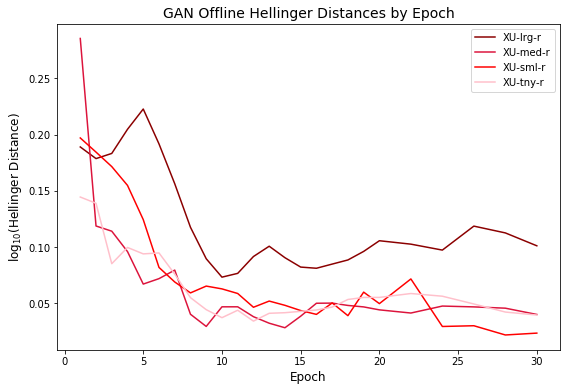

In [87]:
plt.figure(figsize=(9,6))
#gan_configs = ["XU-lrg-w", "XU-med-w", "XU-sml-w", "XU-tny-w",
#
gan_configs = ["XU-lrg-r", "XU-med-r", "XU-sml-r", "XU-tny-r"]
#colors = ["darkblue", "blue", "royalblue", "skyblue",
colors = ["darkred", "crimson", "red", "pink"]
for h, hs in enumerate(out):
    plt.plot(epochs, hs, color=colors[h], label=gan_configs[h])
plt.legend()
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("$\log_{10}($Hellinger Distance$)$", fontsize=12)
plt.title("GAN Offline Hellinger Distances by Epoch", fontsize=14)
plt.savefig("gan_offline_hellinger.pdf", bbox_inches="tight")

In [58]:
disc_files = sorted(glob(join(data_path, "gan_discriminator_0402_*.h5")))
x_range = np.arange(-5, 5.1, 0.1)
u_range = np.arange(-5, 5.1, 0.1)
d_pred = np.zeros((len(disc_files), x_range.size, u_range.size))
for d, disc_file in enumerate(disc_files):
    print(disc_file)
    gan_disc = load_model(disc_file)
    for i, x in enumerate(x_range):
        for j, u in enumerate(u_range): 
            d_pred[d, i, j] = gan_disc.predict([np.array([[x]]), np.array([[[u]]])])

/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0001.h5


/glade/u/home/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0002.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0003.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0004.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0005.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0006.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0007.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0008.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0009.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0010.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0011.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0012.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0013.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0014.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0015.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_0016.h5
/glade/work/dgagne/exp_20_stoch/gan_discriminator_0402_

In [35]:
x_range.shape

(101,)

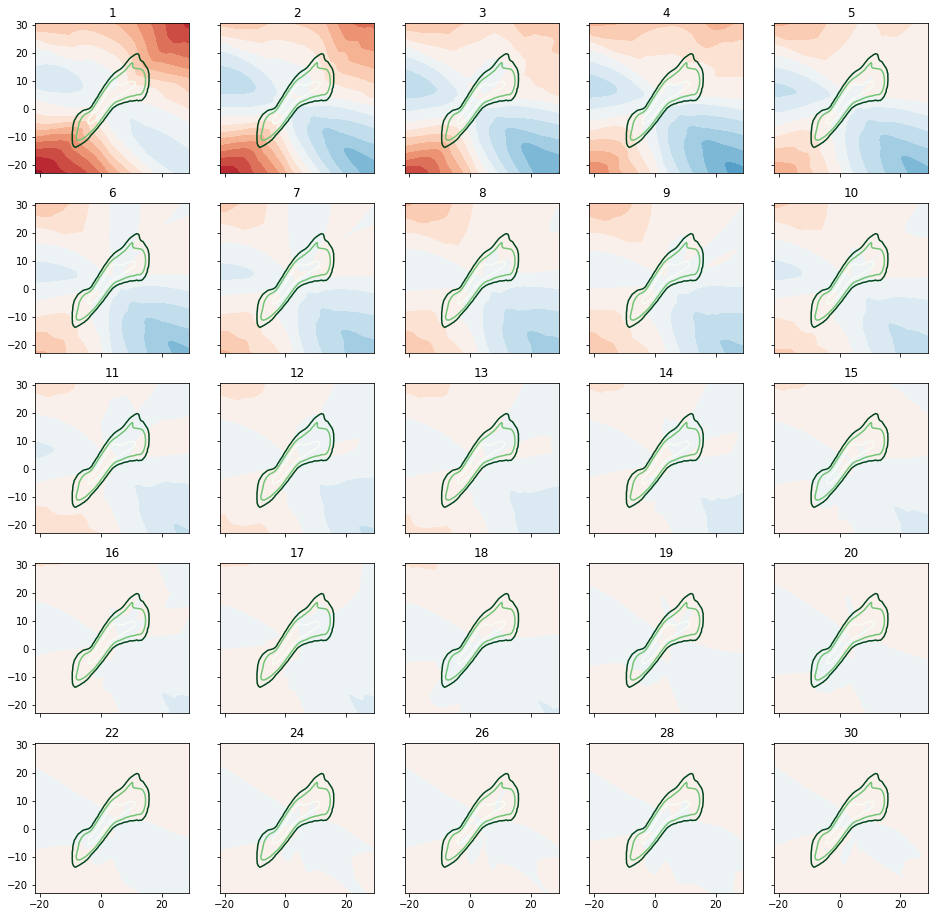

In [59]:
fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=True, sharey=True)
for a, ax in enumerate(axes.ravel()):
    ax.contourf(x_range * 5.06 + 3.766, u_range * 5.34 + 3.88, d_pred[a].T, np.arange(0, 1.05, 0.05), cmap="RdBu_r")
    ax.contour(x_range[:-1] * 5.06 + 3.766, u_range[:-1] * 5.34 + 3.88, h_out[0].T, np.logspace(2, 4, 3), norm=LogNorm(), cmap="Greens_r")
    ax.set_title(epochs[a])

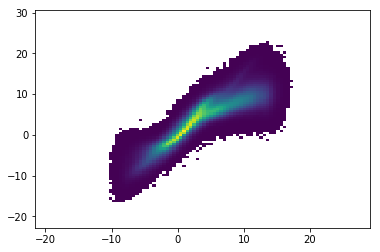

In [29]:
h_out = plt.hist2d(test_data["X_t"], test_data["Ux_t+1"], bins=(x_range * 5.06 + 3.766, u_range * 5.34 + 3.88), cmin=1)

In [41]:
np.nanmax(h_out[0])

31094.0

In [70]:
gen_files = sorted(glob(join(data_path, "gan_generator_0101_*.h5")))
hds_101 = []
for gen_file in gen_files:
    print(gen_file)
    gen = load_model(gen_file)
    pred_func = predict_stochastic(gen)
    gen_preds = pred_func([x_norm_data[:100000], np.random.normal(size=(100000, 1)), 1])[0]
    print(gen_preds.shape)
    kde_pred = KernelDensity(bandwidth=0.5)
    kde_pred.fit(gen_preds[:, :, 0])
    gen_dist = np.exp(kde_pred.score_samples(y_bins.reshape(-1,1)))
    hds_101.append(hellinger(gen_dist, true_pdf))

/glade/work/dgagne/exp_20_stoch/gan_generator_0101_epoch_0001.h5
(100000, 1, 1)
/glade/work/dgagne/exp_20_stoch/gan_generator_0101_epoch_0002.h5
(100000, 1, 1)
/glade/work/dgagne/exp_20_stoch/gan_generator_0101_epoch_0003.h5
(100000, 1, 1)
/glade/work/dgagne/exp_20_stoch/gan_generator_0101_epoch_0004.h5
(100000, 1, 1)
/glade/work/dgagne/exp_20_stoch/gan_generator_0101_epoch_0005.h5
(100000, 1, 1)
/glade/work/dgagne/exp_20_stoch/gan_generator_0101_epoch_0006.h5
(100000, 1, 1)
/glade/work/dgagne/exp_20_stoch/gan_generator_0101_epoch_0007.h5
(100000, 1, 1)
/glade/work/dgagne/exp_20_stoch/gan_generator_0101_epoch_0008.h5
(100000, 1, 1)
/glade/work/dgagne/exp_20_stoch/gan_generator_0101_epoch_0009.h5
(100000, 1, 1)
/glade/work/dgagne/exp_20_stoch/gan_generator_0101_epoch_0010.h5
(100000, 1, 1)
/glade/work/dgagne/exp_20_stoch/gan_generator_0101_epoch_0011.h5
(100000, 1, 1)
/glade/work/dgagne/exp_20_stoch/gan_generator_0101_epoch_0012.h5
(100000, 1, 1)
/glade/work/dgagne/exp_20_stoch/gan_gene

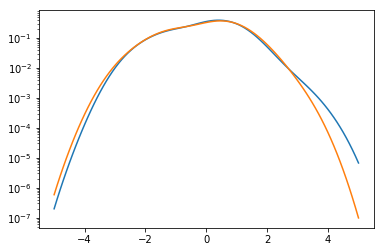

In [77]:
plt.plot(y_bins, gen_dist)
plt.plot(y_bins, true_pdf)
plt.gca().set_yscale("log")

In [24]:
ls /glade/work/dgagne/exp_20_stoch/*.nc

/glade/work/dgagne/exp_20_stoch/annres_config_0000_mean.nc
/glade/work/dgagne/exp_20_stoch/annres_config_0000_res.nc
/glade/work/dgagne/exp_20_stoch/lorenz_output.nc


In [7]:
lorenz_truth = xr.open_dataset("/glade/work/dgagne/exp_20_stoch/lorenz_output.nc")

In [8]:
X_out = lorenz_truth["lorenz_x"].values
t_skip = 5
t_s = np.arange(2, X_out.shape[0] - 1, t_skip)


In [9]:
k = 0
F = 20
K = 32
dt = 0.005
ux_series = (-X_out[t_s, k - 1] * (X_out[t_s, k - 2] - X_out[t_s, (k + 1) % K]) - X_out[t_s, k] + F) - (X_out[t_s + 1, k] - X_out[t_s, k]) / dt

In [10]:
ux_series

array([-7.03072146, -1.73306008, -0.76312538, ..., -4.7843962 ,
       -7.75189375, -9.2823442 ])

In [15]:
gan_202 = load_model("/glade/work/dgagne/exp_20_stoch/gan_generator_0402_epoch_0030.h5", custom_objects={"Split1D":Split1D, "Scale":Scale})

In [21]:
gan_preds = gan_202.predict([(X_out[t_s, 0:1] - x_scaling_values.loc[0, "mean"]) / x_scaling_values.loc[0, "std"], np.zeros(shape=(len(t_s), 17))])

In [22]:
real_gan_preds = gan_preds* y_scaling_values.loc[0, "std"] + y_scaling_values.loc[0, "mean"]

In [24]:
real_gan_preds.min()

-13.710516

(array([7.30000e+01, 1.91900e+03, 2.89570e+04, 1.82652e+05, 3.12742e+05,
        2.00325e+05, 6.34590e+04, 9.07400e+03, 6.82000e+02, 3.70000e+01]),
 array([-12.05580361,  -9.47575661,  -6.89570962,  -4.31566263,
         -1.73561563,   0.84443136,   3.42447835,   6.00452535,
          8.58457234,  11.16461933,  13.74466633]),
 <a list of 10 Patch objects>)

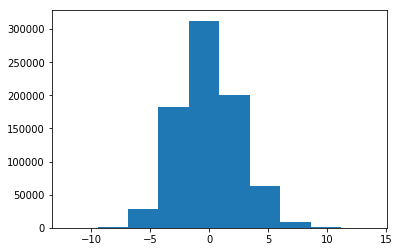

In [32]:
plt.hist(real_gan_preds.ravel() - ux_series)

In [33]:
diffs = real_gan_preds.ravel() - ux_series

In [34]:
np.corrcoef(diffs[1:], diffs[:-1])

array([[1.        , 0.85345721],
       [0.85345721, 1.        ]])

In [143]:
pred_func([np.random.normal(size=(len(t_s), 2)), np.random.normal(size=(len(t_s), 1)), False])[0].max()

0.55820376

In [79]:
y_scaling_values.loc[0, "mean"]

3.8814065

In [90]:
y_scaling_values.loc[0, 'mean']

3.8814065

In [112]:
gan_202.predict([np.array([[0]]), np.array([[[5]]])])

array([[0.36011982]], dtype=float32)